# Strava Data Project

Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import calendar
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sqlalchemy import create_engine
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from pandas.plotting import register_matplotlib_converters

In [3]:
ROOT_DIR = os.path.dirname(os.path.abspath('Strava.ipynb'))
#ROOT_DIR = os.path.dirname('Strava.ipynb')

json_file = open(os.path.join(ROOT_DIR, 'strava_config1.json'), 'r')
json_str = json_file.read()

redshift_info = json.loads(json_str)['redshift_credentials']

db_name = redshift_info['db_name']
iam_user = redshift_info['iam_user']
iam_password = redshift_info['iam_password']
endpoint = redshift_info['endpoint']
table_name = redshift_info['table_name']

register_matplotlib_converters()

Put table from Redshift into a dataframe

In [4]:
engine = create_engine(f'redshift+psycopg2://{iam_user}:{iam_password}@{endpoint}/{db_name}')
df = pd.read_sql_query(f'SELECT * FROM public.{table_name} ORDER BY start_date DESC',con=engine)

## Lets Take An Initial Look At The Data

In [5]:
df

,id,name,start_date,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m,type,manual_entry
0,3232561348,Just as Martin Luther nailed the 99 theses to ...,2020-03-29 16:48:25,3.77,19.7,87,120.0,Run,False
1,3228787917,I've lived in Bozeman for 4 years and this is ...,2020-03-28 16:34:00,3.90,27.4,117,180.0,Run,False
2,3225876867,Catching up with Hattie (and Sydni),2020-03-27 16:53:49,2.37,20.9,147,662.0,Run,False
3,3221892056,Blocking Michael on Strava seems to have lifte...,2020-03-26 20:44:05,3.75,20.9,93,158.0,Run,False
4,3217952831,"I don't do it because it's easy, I do it becau...",2020-03-25 18:42:57,3.73,19.4,86,162.0,Run,False
...,...,...,...,...,...,...,...,...,...
1704,607726595,Morning Run,2016-05-20 18:15:13,2.99,24.3,135,235.0,Run,False
1705,607726584,Afternoon Run,2016-05-18 21:21:11,3.76,4.8,21,84.0,Run,False
1706,607726597,Lunch Run,2016-05-16 20:42:08,3.59,12.6,58,170.0,Run,False
1707,607726580,Afternoon Ride,2016-05-12 22:05:14,7.01,24.8,58,194.0,Ride,False


In [20]:
df.describe()

,id,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m
count,1.709000e+03,1709.000000,1709.000000,1709.000000,1709.000000
mean,1.704654e+09,3.295629,12.827384,70.170275,227.491750
std,7.525940e+08,0.938548,8.372386,57.852501,389.562262
min,6.065143e+08,0.000000,0.000000,1.000000,0.000000
25%,1.052707e+09,3.100000,7.300000,36.000000,30.500000
50%,1.559256e+09,3.460000,11.700000,62.000000,85.000000
75%,2.306060e+09,3.660000,16.100000,83.000000,198.000000
max,3.232561e+09,11.920000,103.400000,737.000000,4042.000000


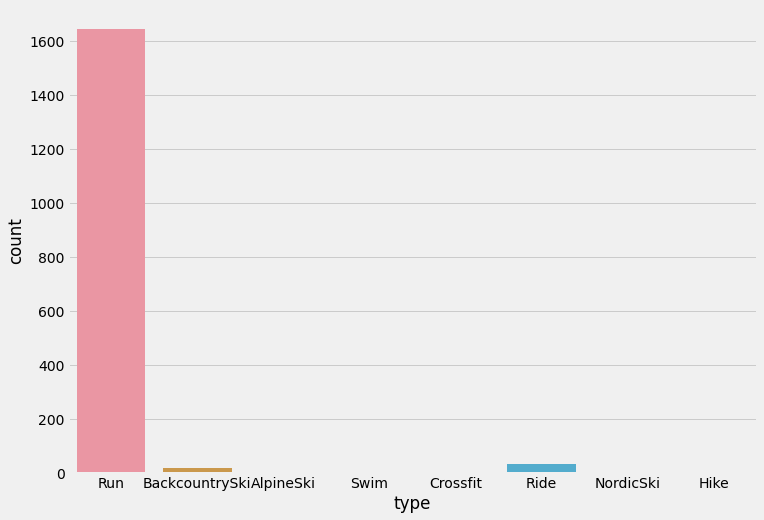

In [21]:
plt.style.use('fivethirtyeight')
dimensions = (11, 8)
fig, ax = plt.subplots(figsize=dimensions)
sns.countplot(ax=ax, x="type", data=df);

In [22]:
df['type'].value_counts()

Run               1646
Ride                36
BackcountrySki      19
Swim                 4
Hike                 1
NordicSki            1
Crossfit             1
AlpineSki            1
Name: type, dtype: int64

### Lets focus on the running data since there isn't substantial data on other activities

In [23]:
df = df.loc[df.type == 'Run']

In [24]:
df

,id,name,start_date,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m,type,manual_entry
0,3232561348,Just as Martin Luther nailed the 99 theses to ...,2020-03-29 16:48:25,3.77,19.7,87,120.0,Run,False
1,3228787917,I've lived in Bozeman for 4 years and this is ...,2020-03-28 16:34:00,3.90,27.4,117,180.0,Run,False
2,3225876867,Catching up with Hattie (and Sydni),2020-03-27 16:53:49,2.37,20.9,147,662.0,Run,False
3,3221892056,Blocking Michael on Strava seems to have lifte...,2020-03-26 20:44:05,3.75,20.9,93,158.0,Run,False
4,3217952831,"I don't do it because it's easy, I do it becau...",2020-03-25 18:42:57,3.73,19.4,86,162.0,Run,False
...,...,...,...,...,...,...,...,...,...
1703,607726601,Lunch Run,2016-05-22 20:00:23,3.47,13.7,65,336.0,Run,False
1704,607726595,Morning Run,2016-05-20 18:15:13,2.99,24.3,135,235.0,Run,False
1705,607726584,Afternoon Run,2016-05-18 21:21:11,3.76,4.8,21,84.0,Run,False
1706,607726597,Lunch Run,2016-05-16 20:42:08,3.59,12.6,58,170.0,Run,False


## When do you run?

### By Year

As we can see it looks like the most activities were recorded in 2018

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


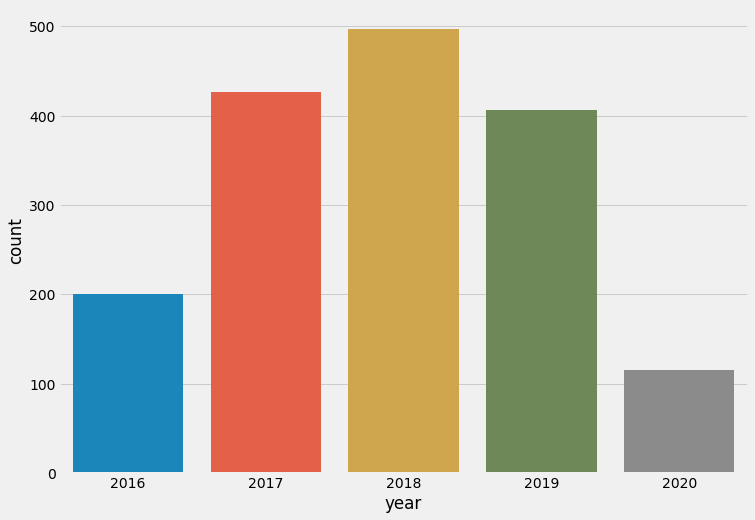

In [26]:
df.loc[:,'year'] = df.loc[:,'start_date'].dt.year
fig, ax = plt.subplots(figsize=dimensions)
sns.countplot(ax = ax, x="year", data=df)

but number of activities doesnt tell the whole story if we look at the overall time spent running has increased almost every year

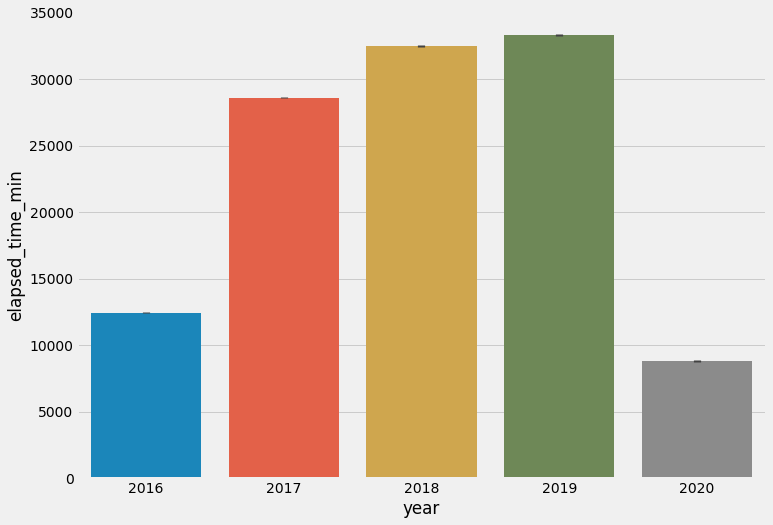

In [239]:
fig, ax = plt.subplots(figsize=dimensions)
sns.barplot(ax =ax, x="year", y="elapsed_time_min", estimator =sum, ci = None , data=df)

We can see that years have stayed fairly consistent and that 2020 looks like it is on track to be the best year yet

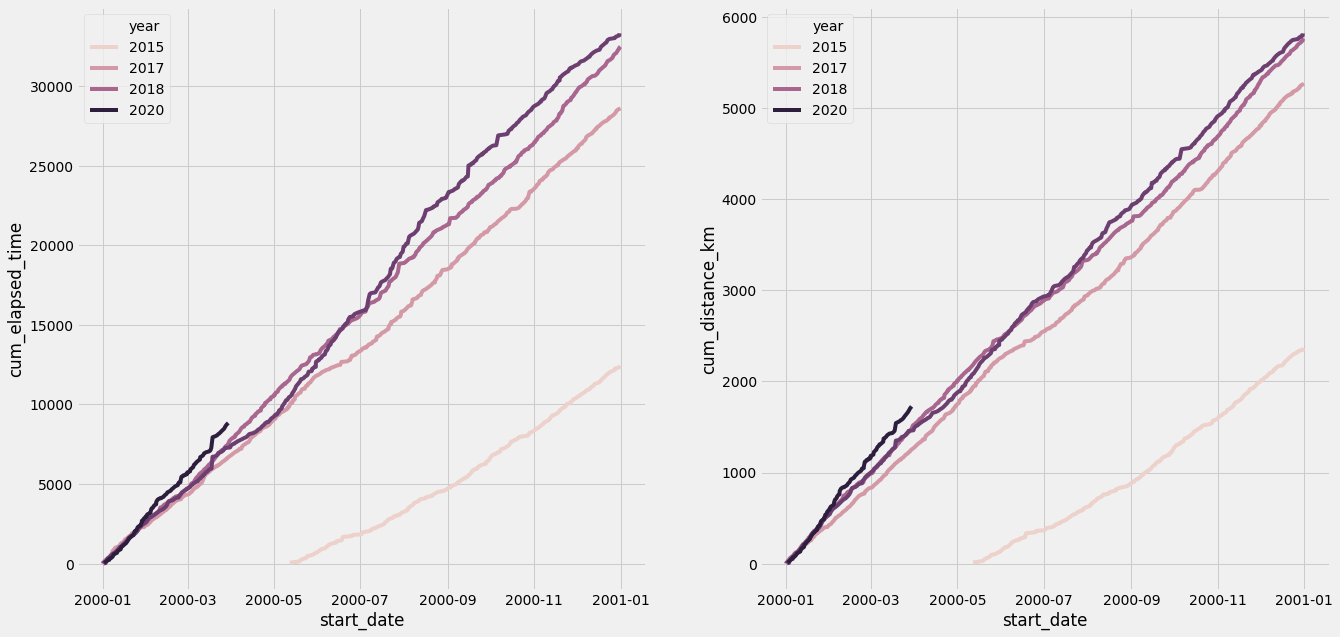

In [32]:
cumulative_df1 = df[['elapsed_time_min', 'start_date', 'year']].copy()
cumulative_df1 = cumulative_df1.sort_values(by=['start_date'])
cumulative_df1['cum_elapsed_time'] = cumulative_df1.groupby(['year'])['elapsed_time_min'].apply(lambda x: x.cumsum())
cumulative_df1['month'] = cumulative_df1['start_date'].dt.month
cumulative_df1['start_date'] = cumulative_df1['start_date'].map(lambda t: t.replace(year=2000))
cumulative_df2 = df[['distance_km', 'start_date', 'year']].copy()
cumulative_df2 = cumulative_df2.sort_values(by=['start_date'])
cumulative_df2['cum_distance_km'] = cumulative_df2.groupby(['year'])['distance_km'].apply(lambda x: x.cumsum())
cumulative_df2['month'] = cumulative_df2['start_date'].dt.month
cumulative_df2['start_date'] = cumulative_df2['start_date'].map(lambda t: t.replace(year=2000))

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1, 2, 1)
sns.lineplot(ax =ax, x="start_date", y="cum_elapsed_time", hue = "year", data=cumulative_df1)
ax = plt.subplot(1, 2, 2)
sns.lineplot(x="start_date", y="cum_distance_km", hue = "year", data=cumulative_df2)

In [ ]:
sns.lineplot(x="start_date", y="cum_distance_km", hue = "year", data=cumulative_df2)

In [30]:
cumulative_df1.loc[:,'start_date'].head()

1708   2000-05-12 03:44:17
1706   2000-05-16 20:42:08
1705   2000-05-18 21:21:11
1704   2000-05-20 18:15:13
1703   2000-05-22 20:00:23
Name: start_date, dtype: datetime64[ns]

We can also see that the average run times seem to have increased as well

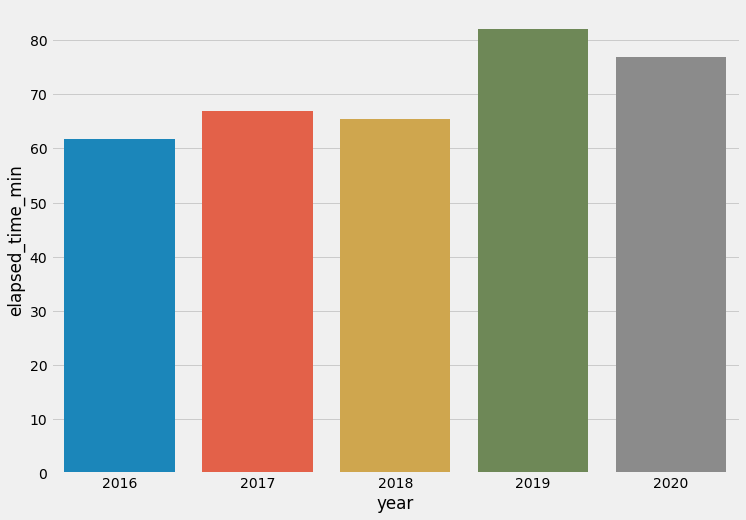

In [241]:
fig, ax = plt.subplots(figsize=dimensions)
sns.barplot(x="year", y="elapsed_time_min", ci = None, data=df)

Combine activity time for days with more than one run

In [238]:
heat_map = df[['start_date', 'elapsed_time_min']]
heat_map.loc[:,'start_date'] = heat_map['start_date'].dt.date
heat_map.groupby(['start_date']).sum()
heat_map.loc[:,'weekday'] = df['start_date'].dt.dayofweek
heat_map.loc[:,'month'] = df['start_date'].dt.month
del heat_map['start_date']
heat_map = heat_map.sort_values(by=['month', 'weekday'])

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


Add weekday and month columns to make it easier to input into the heatmap

In [225]:
heat_map = heat_map.pivot_table('elapsed_time_min', 'month', 'weekday')

In [226]:
heat_map = heat_map.rename(lambda x: calendar.month_abbr[x])
heat_map = heat_map.rename(columns = lambda x: calendar.day_abbr[x])

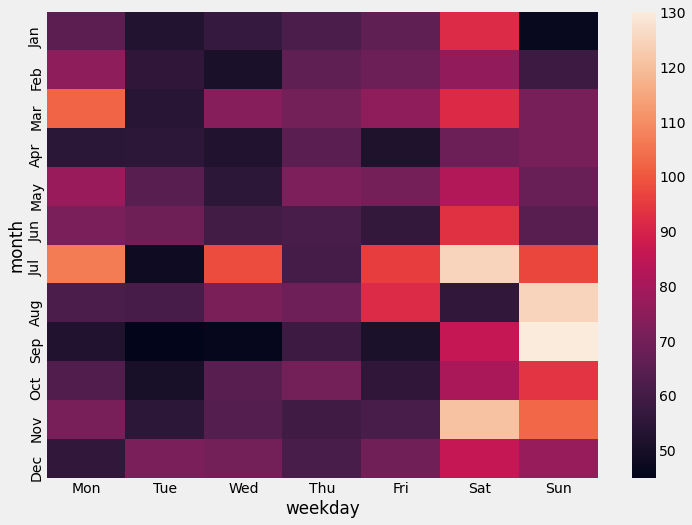

In [227]:
fig, ax = plt.subplots(figsize=dimensions)
sns.heatmap(heat_map, ax = ax)

In [228]:
df

,id,name,start_date,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m,type,manual_entry,year
0,3232561348,Just as Martin Luther nailed the 99 theses to ...,2020-03-29 16:48:25,3.77,19.7,87,120.0,Run,False,2020
1,3228787917,I've lived in Bozeman for 4 years and this is ...,2020-03-28 16:34:00,3.90,27.4,117,180.0,Run,False,2020
2,3225876867,Catching up with Hattie (and Sydni),2020-03-27 16:53:49,2.37,20.9,147,662.0,Run,False,2020
3,3221892056,Blocking Michael on Strava seems to have lifte...,2020-03-26 20:44:05,3.75,20.9,93,158.0,Run,False,2020
4,3217952831,"I don't do it because it's easy, I do it becau...",2020-03-25 18:42:57,3.73,19.4,86,162.0,Run,False,2020
...,...,...,...,...,...,...,...,...,...,...
1703,607726601,Lunch Run,2016-05-22 20:00:23,3.47,13.7,65,336.0,Run,False,2016
1704,607726595,Morning Run,2016-05-20 18:15:13,2.99,24.3,135,235.0,Run,False,2016
1705,607726584,Afternoon Run,2016-05-18 21:21:11,3.76,4.8,21,84.0,Run,False,2016
1706,607726597,Lunch Run,2016-05-16 20:42:08,3.59,12.6,58,170.0,Run,False,2016


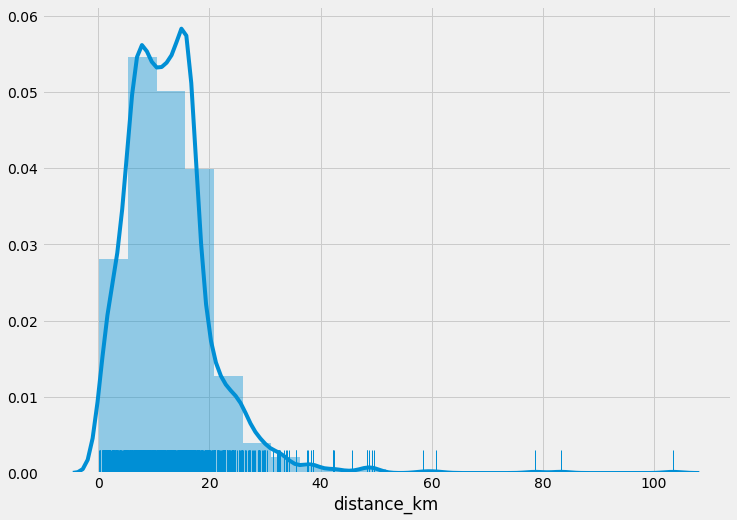

In [229]:
fig, ax = plt.subplots(figsize=dimensions)
sns.distplot(df['distance_km'], bins=20, rug=True, ax = ax);

In [230]:
pd.qcut(df['distance_km'], q=4)

0        (16.1, 103.4]
1        (16.1, 103.4]
2        (16.1, 103.4]
3        (16.1, 103.4]
4        (16.1, 103.4]
             ...      
1703      (11.8, 16.1]
1704     (16.1, 103.4]
1705    (0.199, 7.225]
1706      (11.8, 16.1]
1708      (11.8, 16.1]
Name: distance_km, Length: 1646, dtype: category
Categories (4, interval[float64]): [(0.199, 7.225] < (7.225, 11.8] < (11.8, 16.1] < (16.1, 103.4]]

In [237]:
bins = [0, 5.5, 10.5, 15.5, np.inf]
df['distance_bins_km'] = pd.cut(df['distance_km'], bins = bins)
df['distance_bins_int'] = pd.cut(df['distance_km'], bins = bins, labels = False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [232]:
df

,id,name,start_date,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m,type,manual_entry,year,distance_bins_km,distance_bins_int
0,3232561348,Just as Martin Luther nailed the 99 theses to ...,2020-03-29 16:48:25,3.77,19.7,87,120.0,Run,False,2020,"(15.5, inf]",3
1,3228787917,I've lived in Bozeman for 4 years and this is ...,2020-03-28 16:34:00,3.90,27.4,117,180.0,Run,False,2020,"(15.5, inf]",3
2,3225876867,Catching up with Hattie (and Sydni),2020-03-27 16:53:49,2.37,20.9,147,662.0,Run,False,2020,"(15.5, inf]",3
3,3221892056,Blocking Michael on Strava seems to have lifte...,2020-03-26 20:44:05,3.75,20.9,93,158.0,Run,False,2020,"(15.5, inf]",3
4,3217952831,"I don't do it because it's easy, I do it becau...",2020-03-25 18:42:57,3.73,19.4,86,162.0,Run,False,2020,"(15.5, inf]",3
...,...,...,...,...,...,...,...,...,...,...,...,...
1703,607726601,Lunch Run,2016-05-22 20:00:23,3.47,13.7,65,336.0,Run,False,2016,"(10.5, 15.5]",2
1704,607726595,Morning Run,2016-05-20 18:15:13,2.99,24.3,135,235.0,Run,False,2016,"(15.5, inf]",3
1705,607726584,Afternoon Run,2016-05-18 21:21:11,3.76,4.8,21,84.0,Run,False,2016,"(0.0, 5.5]",0
1706,607726597,Lunch Run,2016-05-16 20:42:08,3.59,12.6,58,170.0,Run,False,2016,"(10.5, 15.5]",2


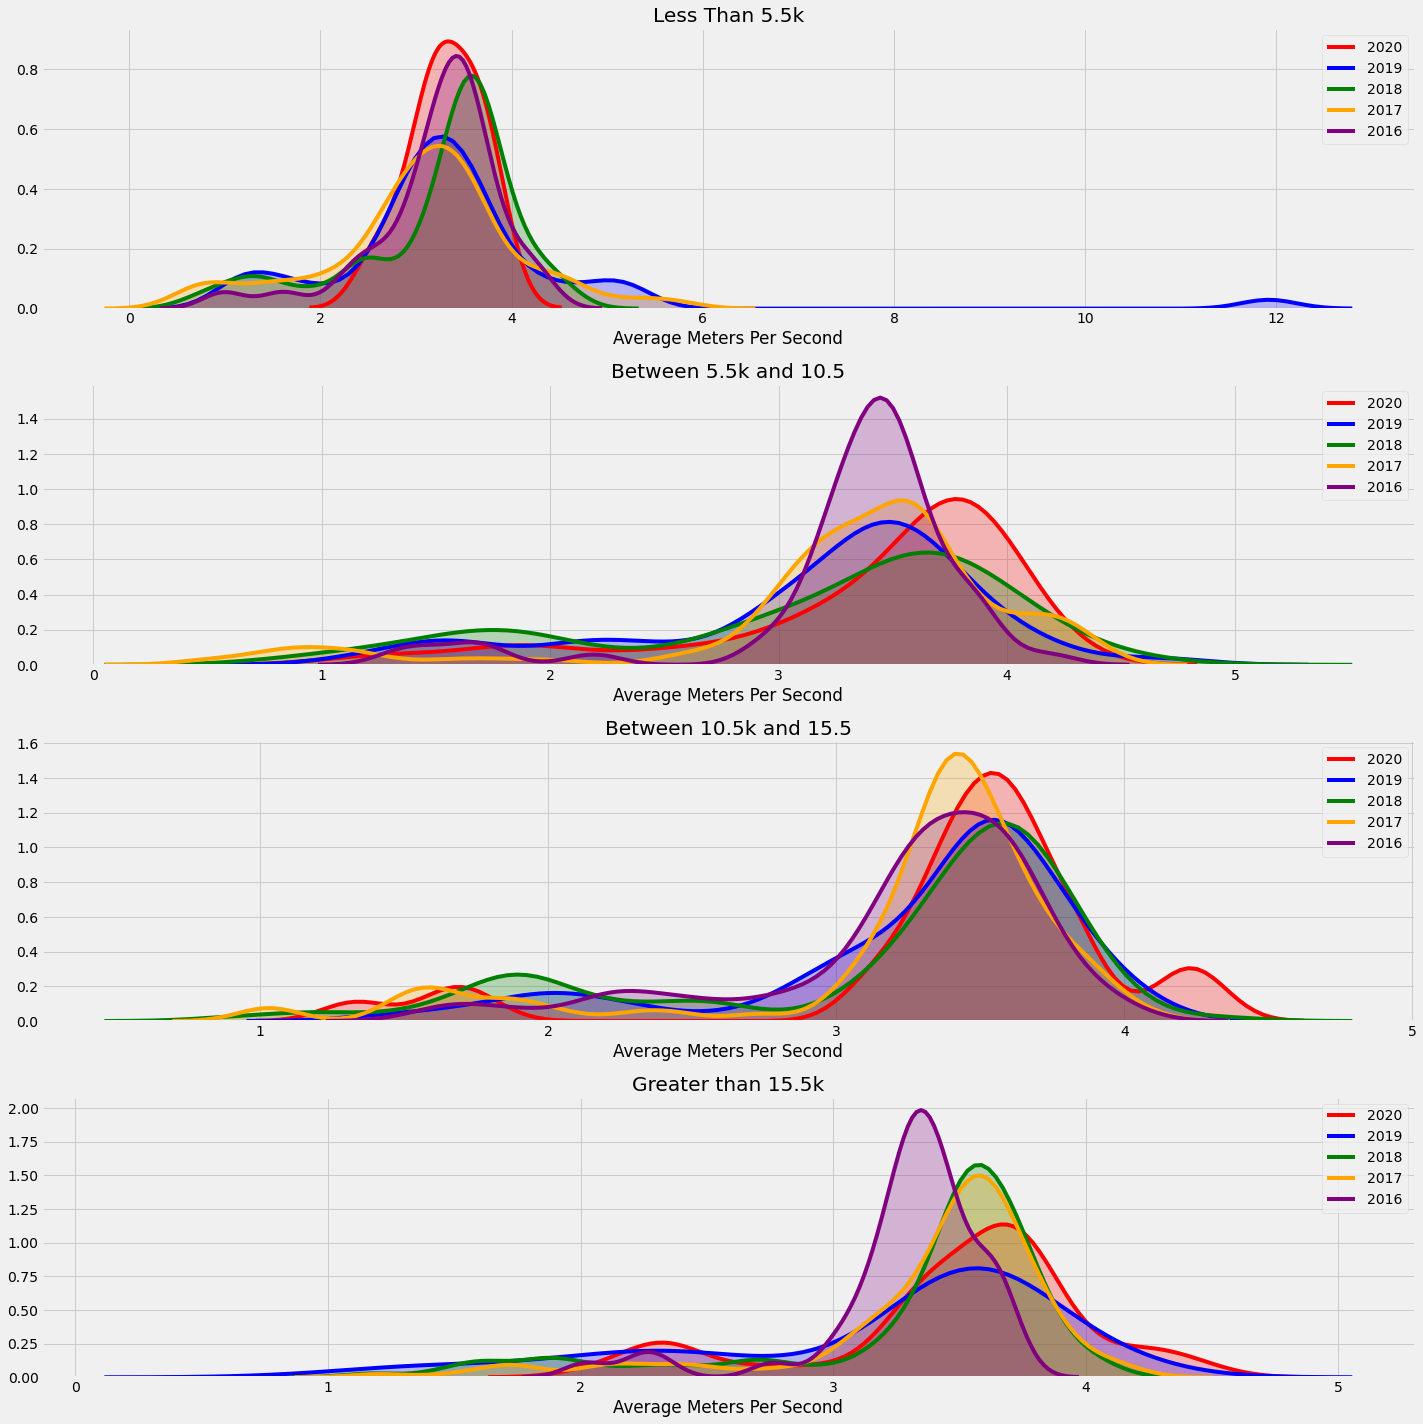

In [233]:
fig = plt.figure(figsize=(20,20))

nrows = 3
year_arr = df['year'].unique()
colors = ['red', 'blue', 'green', 'orange', 'purple']
titles = ["Less Than 5.5k", "Between 5.5k and 10.5","Between 10.5k and 15.5", "Greater than 15.5k"]
ax.legend(year_arr)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    count = 0
    for year in year_arr:
        temp_df = df[df['year'] == year]
        sns.kdeplot(data = temp_df[temp_df['distance_bins_int'] == i]["average_speed_ms"], shade=True, color=colors[count], ax = ax)
        ax.set(label=year, xlabel='Average Meters Per Second', title = titles[i])
        count += 1
    ax.legend(year_arr)
plt.tight_layout()

In [234]:
test = df[df['distance_bins_int'] == 0]

In [235]:
x = widgets.Dropdown(
    options=["elapsed_time_min", "distance_km", "total_elevation_gain_m", "average_speed_ms"],
    value='elapsed_time_min',
    description='x axis:',
    disabled=False,
)
x

Dropdown(description='x axis:', options=('elapsed_time_min', 'distance_km', 'total_elevation_gain_m', 'average…

In [236]:
sns.scatterplot(x=x.value, y=y.value, alpha = .3, data=df.query(f'start_date >= {year_start.value} & start_date <= {year_end.value}'));

NameError: name 'y' is not defined

In [ ]:
df['year'] = df['start_date'].dt.year
sns.relplot(x="elapsed_time_min", y="distance_km", hue= "year", alpha=.5, palette="muted",
            height=6, data=df)